# 05 - Advanced Models

Goal: train more expressive models and perform light hyperparameter tuning.

Models:
- Random Forest
- XGBoost (if available)
- LightGBM (if available)

We will compare performance on the same train/test split.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path
import numpy as np
import os

# DEBUG: Print current working directory
print(f"Current working directory: {os.getcwd()}")

# Use absolute path resolution to avoid any confusion
# Get the notebook directory, then go up one level to project root
notebook_dir = Path.cwd()
if notebook_dir.name == 'notebooks':
    # We're in the notebooks directory, go up one level
    project_root = notebook_dir.parent
else:
    # We're already in project root
    project_root = notebook_dir

PROCESSED_DIR = project_root / 'data' / 'processed'
RAW_DIR = project_root / 'data' / 'raw'

print(f"Project root: {project_root}")
print(f"PROCESSED_DIR: {PROCESSED_DIR}")
print(f"RAW_DIR: {RAW_DIR}")
print(f"PROCESSED_DIR exists: {PROCESSED_DIR.exists()}")
print(f"RAW_DIR exists: {RAW_DIR.exists()}")

def load_or_create_data():
    # Check if the processed directory and all files exist
    required_files = [
        PROCESSED_DIR / 'X_train_scaled.csv',
        PROCESSED_DIR / 'X_test_scaled.csv',
        PROCESSED_DIR / 'y_train.csv',
        PROCESSED_DIR / 'y_test.csv'
    ]
    
    print("\nChecking for required files:")
    for f in required_files:
        print(f"  {f}: exists={f.exists()}")
    
    missing_files = [str(f) for f in required_files if not f.exists()]

    if missing_files:
        print("\nWarning: The following required files are missing:")
        for f in missing_files:
            print(f"  - {f}")
        print("Generating new train/test split from raw data...")

        # Try both 'data.csv' and 'credit_card_fraud_dataset.csv'
        possible_raw_files = [RAW_DIR/'data.csv', RAW_DIR / 'credit_card_fraud_dataset.csv']
        
        print("\nLooking for raw data files:")
        for f in possible_raw_files:
            print(f"  {f}: exists={f.exists()}")
        
        raw_file = None
        for candidate in possible_raw_files:
            if candidate.exists():
                raw_file = candidate
                print(f"\nFound raw data file: {raw_file}")
                break

        # If file(s) not found, prompt the user what to do next
        if raw_file is None:
            # List what files exist in the raw dir for user assistance
            available_files = list(RAW_DIR.glob("*.csv")) if RAW_DIR.exists() else []
            print(f"\nCould not find the required raw data file in: {RAW_DIR}")
            if available_files:
                print("Available csv files in data/raw/:")
                for f in available_files:
                    print(f"  - {f}")
                print("Please rename the appropriate raw file to 'data.csv' or update the code to use the correct filename.")
            else:
                print("No CSV files found in the data/raw directory.")
                print("Please place your raw data file (with a 'target' column) named 'data.csv' in the data/raw directory.")
            raise FileNotFoundError(f"Raw data file not found. Checked: {[str(f) for f in possible_raw_files]}")
        
        # Load raw data and generate split
        print(f"\nLoading raw data from: {raw_file}")
        df = pd.read_csv(raw_file)
        print(f"Loaded dataframe with shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        
        if 'target' not in df.columns:
            raise ValueError("Raw data must contain a 'target' column.")

        X = df.drop(columns=['target'])
        y = df['target']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Save processed
        PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
        X_train.to_csv(PROCESSED_DIR / 'X_train_scaled.csv', index=False)
        X_test.to_csv(PROCESSED_DIR / 'X_test_scaled.csv', index=False)
        y_train.to_csv(PROCESSED_DIR / 'y_train.csv', index=False)
        y_test.to_csv(PROCESSED_DIR / 'y_test.csv', index=False)
        print(f"\nSaved processed files to: {PROCESSED_DIR}")
    else:
        print("\nLoading existing processed data files...")
        X_train = pd.read_csv(PROCESSED_DIR / 'X_train_scaled.csv')
        X_test = pd.read_csv(PROCESSED_DIR / 'X_test_scaled.csv')
        y_train = pd.read_csv(PROCESSED_DIR / 'y_train.csv').squeeze()
        y_test = pd.read_csv(PROCESSED_DIR / 'y_test.csv').squeeze()
        print(f"Loaded X_train: {X_train.shape}, X_test: {X_test.shape}")
        print(f"Loaded y_train: {y_train.shape}, y_test: {y_test.shape}")
        return X_train, X_test, y_train, y_test

    # After creation, reload to ensure consistent behavior
    X_train = pd.read_csv(PROCESSED_DIR / 'X_train_scaled.csv')
    X_test = pd.read_csv(PROCESSED_DIR / 'X_test_scaled.csv')
    y_train = pd.read_csv(PROCESSED_DIR / 'y_train.csv').squeeze()
    y_test = pd.read_csv(PROCESSED_DIR / 'y_test.csv').squeeze()
    print(f"Loaded X_train: {X_train.shape}, X_test: {X_test.shape}")
    print(f"Loaded y_train: {y_train.shape}, y_test: {y_test.shape}")
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_or_create_data()

print("\n" + "="*50)
print("Starting model training...")
print("="*50)

# Random Forest with simple search
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
param_dist = {
    'n_estimators': [200, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_
rf_probs = rf_best.predict_proba(X_test)[:,1]
rf_report = classification_report(y_test, rf_best.predict(X_test), output_dict=True)
rf_auc = roc_auc_score(y_test, rf_probs)

results = {'random_forest': {'report': rf_report, 'roc_auc': rf_auc}}

# Optional: XGBoost
try:
    from xgboost import XGBClassifier
    xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        scale_pos_weight=(len(y_train)-y_train.sum())/y_train.sum(),
        random_state=42,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist'
    )
    xgb.fit(X_train, y_train)
    xgb_probs = xgb.predict_proba(X_test)[:,1]
    results['xgboost'] = {
        'report': classification_report(y_test, xgb.predict(X_test), output_dict=True),
        'roc_auc': roc_auc_score(y_test, xgb_probs)
    }
except Exception as e:
    results['xgboost'] = {'error': str(e)}

# Optional: LightGBM
try:
    import lightgbm as lgb
    lgb_model = lgb.LGBMClassifier(
        class_weight='balanced',
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=64,
        random_state=42
    )
    lgb_model.fit(X_train, y_train)
    lgb_probs = lgb_model.predict_proba(X_test)[:,1]
    results['lightgbm'] = {
        'report': classification_report(y_test, lgb_model.predict(X_test), output_dict=True),
        'roc_auc': roc_auc_score(y_test, lgb_probs)
    }
except Exception as e:
    results['lightgbm'] = {'error': str(e)}

results

Current working directory: c:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection\notebooks
Project root: c:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection
PROCESSED_DIR: c:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection\data\processed
RAW_DIR: c:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection\data\raw
PROCESSED_DIR exists: True
RAW_DIR exists: True

Checking for required files:
  c:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection\data\processed\X_train_scaled.csv: exists=True
  c:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection\data\processed\X_test_scaled.csv: exists=True
  c:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection\data\processed\y_train.csv: exists=True
  c:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection\data\processed\y_test.csv: exists=True

Loading existing processed data files...
Loaded X_train: (80000, 375), X_test: (20000, 375)
Loaded y_train: (80000,), y_test: (20000,)

Starting model training...
[LightG

{'random_forest': {'report': {'0': {'precision': 0.9895646674396542,
    'recall': 0.9482828282828283,
    'f1-score': 0.9684840356940217,
    'support': 19800.0},
   '1': {'precision': 0.001949317738791423,
    'recall': 0.01,
    'f1-score': 0.0032626427406199023,
    'support': 200.0},
   'accuracy': 0.9389,
   'macro avg': {'precision': 0.4957569925892228,
    'recall': 0.47914141414141415,
    'f1-score': 0.48587333921732084,
    'support': 20000.0},
   'weighted avg': {'precision': 0.9796885139426457,
    'recall': 0.9389,
    'f1-score': 0.9588318217644879,
    'support': 20000.0}},
  'roc_auc': 0.48721893939393945},
 'xgboost': {'report': {'0': {'precision': 0.9898915021227845,
    'recall': 0.7418686868686869,
    'f1-score': 0.8481191720315252,
    'support': 19800.0},
   '1': {'precision': 0.00968804495252858,
    'recall': 0.25,
    'f1-score': 0.018653236336504384,
    'support': 200.0},
   'accuracy': 0.73695,
   'macro avg': {'precision': 0.4997897735376566,
    'recall'

Feature importance (where available) should be captured and saved to `results/metrics` for later visualization.

In [2]:
# Display results in a formatted table
import pandas as pd
from pathlib import Path
import json

# Create results directories if they don't exist
RESULTS_DIR = Path('../results')
METRICS_DIR = RESULTS_DIR / 'metrics'
METRICS_DIR.mkdir(parents=True, exist_ok=True)

# Create a comparison table for all models
comparison_data = []

for model_name, model_results in results.items():
    if 'error' in model_results:
        # If model failed, show error
        comparison_data.append({
            'Model': model_name,
            'ROC-AUC': 'Error',
            'Precision (Class 0)': 'N/A',
            'Recall (Class 0)': 'N/A',
            'F1-Score (Class 0)': 'N/A',
            'Precision (Class 1)': 'N/A',
            'Recall (Class 1)': 'N/A',
            'F1-Score (Class 1)': 'N/A',
            'Error': model_results['error']
        })
    else:
        # Extract metrics from classification report
        report = model_results['report']
        comparison_data.append({
            'Model': model_name,
            'ROC-AUC': f"{model_results['roc_auc']:.4f}",
            'Precision (Class 0)': f"{report['0']['precision']:.4f}",
            'Recall (Class 0)': f"{report['0']['recall']:.4f}",
            'F1-Score (Class 0)': f"{report['0']['f1-score']:.4f}",
            'Precision (Class 1)': f"{report['1']['precision']:.4f}",
            'Recall (Class 1)': f"{report['1']['recall']:.4f}",
            'F1-Score (Class 1)': f"{report['1']['f1-score']:.4f}",
            'Accuracy': f"{report['accuracy']:.4f}"
        })

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

print("="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Save comparison table to CSV
comparison_csv_path = METRICS_DIR / '05_advanced_models_comparison.csv'
comparison_df.to_csv(comparison_csv_path, index=False)
print(f"\nSaved comparison table to: {comparison_csv_path}")

# Save detailed results as JSON
results_json_path = METRICS_DIR / '05_advanced_models_detailed_results.json'
with open(results_json_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"Saved detailed results to: {results_json_path}")

# Also display as a nice table if in Jupyter
comparison_df

MODEL PERFORMANCE COMPARISON
        Model ROC-AUC Precision (Class 0) Recall (Class 0) F1-Score (Class 0) Precision (Class 1) Recall (Class 1) F1-Score (Class 1) Accuracy
random_forest  0.4872              0.9896           0.9483             0.9685              0.0019           0.0100             0.0033   0.9389
      xgboost  0.4992              0.9899           0.7419             0.8481              0.0097           0.2500             0.0187   0.7369
     lightgbm  0.4973              0.9898           0.9658             0.9776              0.0044           0.0150             0.0068   0.9563

Saved comparison table to: ..\results\metrics\05_advanced_models_comparison.csv
Saved detailed results to: ..\results\metrics\05_advanced_models_detailed_results.json


,Model,ROC-AUC,Precision (Class 0),Recall (Class 0),F1-Score (Class 0),Precision (Class 1),Recall (Class 1),F1-Score (Class 1),Accuracy
0,random_forest,0.4872,0.9896,0.9483,0.9685,0.0019,0.0100,0.0033,0.9389
1,xgboost,0.4992,0.9899,0.7419,0.8481,0.0097,0.2500,0.0187,0.7369
2,lightgbm,0.4973,0.9898,0.9658,0.9776,0.0044,0.0150,0.0068,0.9563


Saved comparison figure to: ..\results\figures\05_advanced_models_comparison.png


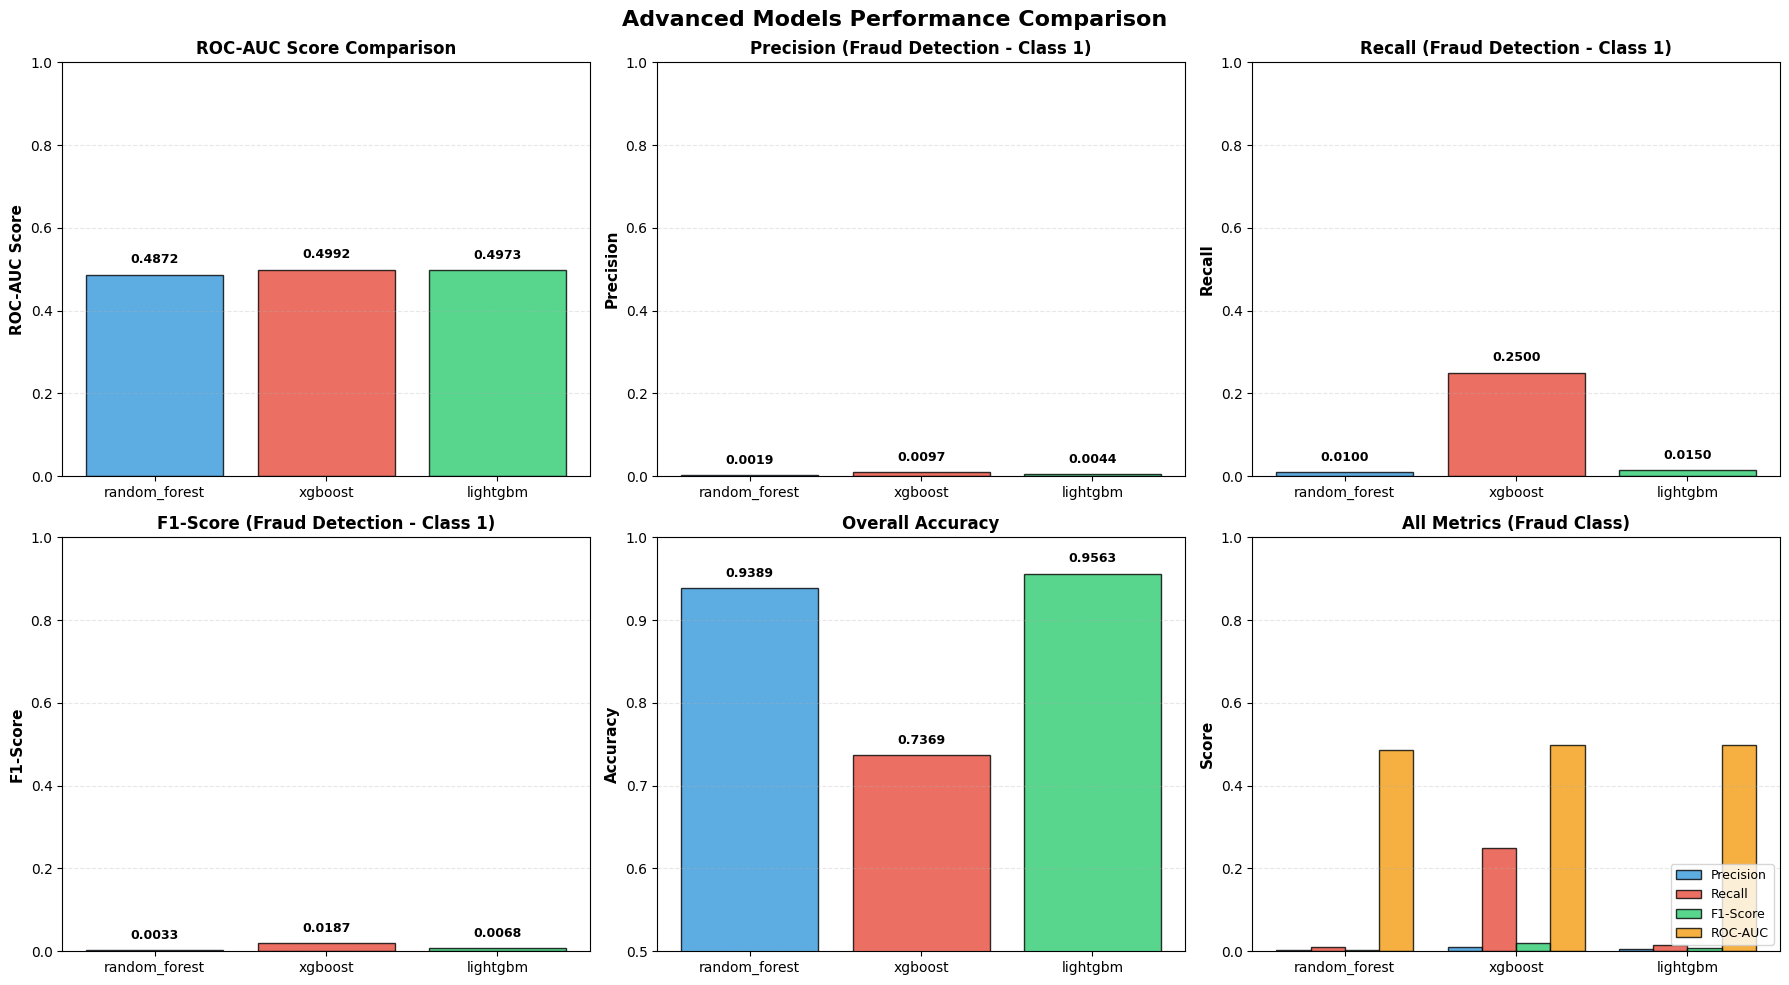


BEST PERFORMING MODELS BY METRIC
Best ROC-AUC:        xgboost              (0.4992)
Best Precision:      xgboost              (0.0097)
Best Recall:         xgboost              (0.2500)
Best F1-Score:       xgboost              (0.0187)


In [3]:
# Visualize model comparison with bar charts
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Create results directories if they don't exist
RESULTS_DIR = Path('../results')
FIGURES_DIR = RESULTS_DIR / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Filter out models with errors for visualization
valid_models = {k: v for k, v in results.items() if 'error' not in v}

if not valid_models:
    print("No models successfully trained. Cannot create visualizations.")
else:
    model_names = list(valid_models.keys())
    
    # Extract metrics for visualization
    roc_auc_scores = [valid_models[m]['roc_auc'] for m in model_names]
    precision_class1 = [valid_models[m]['report']['1']['precision'] for m in model_names]
    recall_class1 = [valid_models[m]['report']['1']['recall'] for m in model_names]
    f1_class1 = [valid_models[m]['report']['1']['f1-score'] for m in model_names]
    accuracy_scores = [valid_models[m]['report']['accuracy'] for m in model_names]
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Advanced Models Performance Comparison', fontsize=16, fontweight='bold')
    
    # Color scheme
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
    
    # 1. ROC-AUC Score
    ax1 = axes[0, 0]
    bars1 = ax1.bar(model_names, roc_auc_scores, color=colors[:len(model_names)], alpha=0.8, edgecolor='black')
    ax1.set_ylabel('ROC-AUC Score', fontsize=11, fontweight='bold')
    ax1.set_title('ROC-AUC Score Comparison', fontsize=12, fontweight='bold')
    ax1.set_ylim([0, 1.0])
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    for i, (bar, score) in enumerate(zip(bars1, roc_auc_scores)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{score:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 2. Precision (Fraud Class)
    ax2 = axes[0, 1]
    bars2 = ax2.bar(model_names, precision_class1, color=colors[:len(model_names)], alpha=0.8, edgecolor='black')
    ax2.set_ylabel('Precision', fontsize=11, fontweight='bold')
    ax2.set_title('Precision (Fraud Detection - Class 1)', fontsize=12, fontweight='bold')
    ax2.set_ylim([0, 1.0])
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    for i, (bar, score) in enumerate(zip(bars2, precision_class1)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{score:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 3. Recall (Fraud Class)
    ax3 = axes[0, 2]
    bars3 = ax3.bar(model_names, recall_class1, color=colors[:len(model_names)], alpha=0.8, edgecolor='black')
    ax3.set_ylabel('Recall', fontsize=11, fontweight='bold')
    ax3.set_title('Recall (Fraud Detection - Class 1)', fontsize=12, fontweight='bold')
    ax3.set_ylim([0, 1.0])
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    for i, (bar, score) in enumerate(zip(bars3, recall_class1)):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{score:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 4. F1-Score (Fraud Class)
    ax4 = axes[1, 0]
    bars4 = ax4.bar(model_names, f1_class1, color=colors[:len(model_names)], alpha=0.8, edgecolor='black')
    ax4.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
    ax4.set_title('F1-Score (Fraud Detection - Class 1)', fontsize=12, fontweight='bold')
    ax4.set_ylim([0, 1.0])
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    for i, (bar, score) in enumerate(zip(bars4, f1_class1)):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{score:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 5. Accuracy
    ax5 = axes[1, 1]
    bars5 = ax5.bar(model_names, accuracy_scores, color=colors[:len(model_names)], alpha=0.8, edgecolor='black')
    ax5.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax5.set_title('Overall Accuracy', fontsize=12, fontweight='bold')
    ax5.set_ylim([0.5, 1.0])
    ax5.grid(axis='y', alpha=0.3, linestyle='--')
    for i, (bar, score) in enumerate(zip(bars5, accuracy_scores)):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 6. All Metrics Grouped
    ax6 = axes[1, 2]
    x = np.arange(len(model_names))
    width = 0.2
    
    bars_prec = ax6.bar(x - 1.5*width, precision_class1, width, label='Precision', 
                        color='#3498db', alpha=0.8, edgecolor='black')
    bars_rec = ax6.bar(x - 0.5*width, recall_class1, width, label='Recall', 
                       color='#e74c3c', alpha=0.8, edgecolor='black')
    bars_f1 = ax6.bar(x + 0.5*width, f1_class1, width, label='F1-Score', 
                      color='#2ecc71', alpha=0.8, edgecolor='black')
    bars_roc = ax6.bar(x + 1.5*width, roc_auc_scores, width, label='ROC-AUC', 
                       color='#f39c12', alpha=0.8, edgecolor='black')
    
    ax6.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax6.set_title('All Metrics (Fraud Class)', fontsize=12, fontweight='bold')
    ax6.set_xticks(x)
    ax6.set_xticklabels(model_names, rotation=0)
    ax6.legend(loc='lower right', fontsize=9)
    ax6.set_ylim([0, 1.0])
    ax6.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Save the figure
    figure_path = FIGURES_DIR / '05_advanced_models_comparison.png'
    plt.savefig(figure_path, dpi=300, bbox_inches='tight')
    print(f"Saved comparison figure to: {figure_path}")
    
    plt.show()
    
    # Print summary
    print("\n" + "="*80)
    print("BEST PERFORMING MODELS BY METRIC")
    print("="*80)
    
    best_roc_idx = np.argmax(roc_auc_scores)
    best_precision_idx = np.argmax(precision_class1)
    best_recall_idx = np.argmax(recall_class1)
    best_f1_idx = np.argmax(f1_class1)
    
    print(f"Best ROC-AUC:        {model_names[best_roc_idx]:20s} ({roc_auc_scores[best_roc_idx]:.4f})")
    print(f"Best Precision:      {model_names[best_precision_idx]:20s} ({precision_class1[best_precision_idx]:.4f})")
    print(f"Best Recall:         {model_names[best_recall_idx]:20s} ({recall_class1[best_recall_idx]:.4f})")
    print(f"Best F1-Score:       {model_names[best_f1_idx]:20s} ({f1_class1[best_f1_idx]:.4f})")
    print("="*80)